# Focusing Data figure
Temporarily called figure 3. Could change. We want to smooth and plot bars with confidence intervals for the data in xixi's new experiments.
This file:
- takes a csv file with raw data
- reformats the data tidily
- normalizes the data
- creates the bootstrap function that randomly samples the data then fits a curve for each random sample
- takes the quantiles from the results of the bootstrap function to find the confidence interval
- creates an integrated data frame for the bar plots
- renormalizes the data for the bar plots
- plots everything above including smoothed curve and confidence intervals
- saves the figure

In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)
library(stringr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



# Figure 3, August 30 2016
Redoing figure 3 with Xixi's new data for focusing for Mannose, and using AMPCPP + the redos.
In the version below there is some issue with the mannose data being only integers in the original file.

## Data reformatting

In [2]:
fig3<- read.csv("../newdata/alldata_083016.csv")

To make this work the initial csv file data must be reformatted as follows:

In [3]:
head(fig3)

,distance,dg,dg.ctrl,amppcp,amppcp.ctrl,mannose.ctrl,mannose,lg.ctrl,lg
1,0,77.1667,81.3333,94.6667,90.3333,75,69,34,30.6667
2,1.8884,81,87.3333,102.667,96.3333,89,83,34.6667,37
3,3.7768,84.8333,93.3333,123.333,93.6667,81,75,40,40.3333
4,5.6652,89.5,96.6667,128.333,109.333,79,73,40.6667,45.3333
5,7.5535,92.3333,100,128.667,116.667,91,85,45.3333,41.3333
6,9.4419,93.1667,97.3333,129,129.333,85,79,44.3333,50


In [4]:
n<-dim(fig3)[1]
fig3<-fig3[1:(n-5),]

In [5]:
tail(fig3) # making sure there are no trailing spaces. modify previous lines if there is

,distance,dg,dg.ctrl,amppcp,amppcp.ctrl,mannose.ctrl,mannose,lg.ctrl,lg
161,302.1419,92.8333,97.6667,114.667,129.333,83,79,37,44
162,304.0303,92.8333,96.6667,108.667,131.667,87,72,39.6667,40.6667
163,305.9187,91.6667,97.6667,108.333,131,83,79,40,41.3333
164,307.8071,90.3333,98,107,131.333,80,71,39,41
165,309.6955,90.6667,97.3333,111.333,130,82,75,38.6667,40.3333
166,311.5839,91.3333,96.6667,108,133,83,72,36.3333,37


In [6]:
fig3 <- gather(fig3,"Experiment","Concentration",dg:lg) # putting the data in tidy format

In [7]:
head(fig3)

,distance,Experiment,Concentration
1,0,dg,77.1667
2,1.8884,dg,81
3,3.7768,dg,84.8333
4,5.6652,dg,89.5
5,7.5535,dg,92.3333
6,9.4419,dg,93.1667


## Data Normalizing

In [8]:
 normalit<-function(m){
     # this function will normalise the fluorescence intensities
   (m - min(m))*100/sum(m-min(m))
 }

In [9]:
# now we normalize all columns by experiment
fig3 %<>% group_by(Experiment) %>% mutate(Concentration.norm = normalit(Concentration))

In [10]:
# doing some regex to splot the columns accordingly
fig3$Substrate = NA
fig3$Substrate <- str_extract(fig3$Experiment, "[a-z]+")
fig3$Experiment <- str_match(fig3$Experiment, "[.]([a-z]+)")[,2]
fig3$Experiment[is.na(fig3$Experiment)] = "substrate"

In [11]:
fig3[200:210,]

,distance,Experiment,Concentration,Concentration.norm,Substrate
1,62.3168,ctrl,102,0.6062382,dg
2,64.2052,ctrl,100.667,0.5671359,dg
3,66.0936,ctrl,102.667,0.625804,dg
4,67.9819,ctrl,101,0.5769042,dg
5,69.8703,ctrl,103.667,0.6551381,dg
6,71.7587,ctrl,101.667,0.59647,dg
7,73.6471,ctrl,102.667,0.625804,dg
8,75.5355,ctrl,103,0.6355723,dg
9,77.4239,ctrl,101,0.5769042,dg
10,79.3123,ctrl,101.667,0.59647,dg


In [12]:
# adding the three channels to our data
fig3$channel <- NA
fig3$channel[fig3$distance <= 100] <- 'left'
fig3$channel[fig3$distance > 100 & fig3$distance <= 220] <- 'center'
fig3$channel[fig3$distance > 220] <- 'right'
fig3$channel <- factor(fig3$channel, levels = c ('left','center','right'))

In [13]:
# transforming the experiment labels to factors so they will be plotted in order
fig3$Substrate <- factor(fig3$Substrate, levels = c ('dg','mannose','lg','amppcp'))

## Creating and running the bootstrap

In [14]:
# this function will run the bootstrap on all iterations of the data and fit the resulting bootstrapped
# data with a smooth curve
run_bootstrap <- function(df,m) {
    temp <- df %>%
        bootstrap(m) %>%
#          do(augment(glm(data = ., Concentration ~ ns(Distance, df = 6)),.))
         do(augment(loess(data = ., Concentration.norm ~ distance, span =0.5),.))
    temp
}

In [15]:
# this runs the bootstrap for a specified number of iterations

N_bootstrap = 200

fig3_bs <- fig3 %>%
    group_by(Substrate,Experiment) %>%
    do(run_bootstrap(., N_bootstrap))

## Calculating confidence intervals

In [16]:
# now that we have the bootstrap functions we can calculate the confidence interval
# this will allow us to plot error bars

alpha <- 0.05
fig3_recap <- fig3_bs %>%
    group_by(Experiment, Substrate, distance,channel) %>% 
    summarise(lo = quantile(.fitted,alpha/2), 
              hi = quantile(.fitted,1-alpha/2), 
              smooth = mean(.fitted), 
              orig = mean(Concentration.norm))
fig3_bs %<>% group_by(Experiment, Substrate, distance,channel) %>% 
    mutate(lo = quantile(.fitted,alpha/2), hi = quantile(.fitted,1-alpha/2))

## Creating integrated dataset for barplots and rescaling

In [17]:
# we create a new data frame with summed data by channel for the barplot

bychannel_recap <- fig3_recap %>% 
    group_by(channel,Substrate,Experiment) %>% 
    summarise(orig = sum(orig), smooth = sum(smooth), lo = sum(lo), hi = sum(hi))

In [18]:
# this is an intermediary step
# we determine the scale factor so that
# the CENTER channel of the CONTROL experiment for DG is 100

a <- bychannel_recap %>% filter(channel == 'center', Experiment == 'ctrl', Substrate == 'dg')
scale <- 100/a$smooth

In [19]:
# now we rescale the recapped data frame according to our scale factor

bychannel_recap <- bychannel_recap %>% mutate(orig = orig*scale, smooth = smooth*scale, lo = lo*scale,
                                              hi = hi*scale)

## Plotting

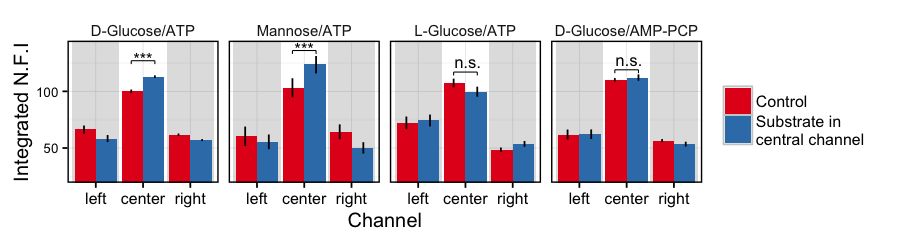

In [20]:
# PLOTTING THE BARPLOTS


options(repr.plot.width = 7.5, repr.plot.height = 2)
integrated <- ggplot(data = bychannel_recap, 
                     aes(x=channel, y= smooth,fill = Experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Channel") +
    ylab("Integrated N.F.I") +
    facet_grid(. ~ Substrate,
       labeller = labeller(Substrate =c(dg = 'D-Glucose/ATP',lg = 'L-Glucose/ATP', mannose = 'Mannose/ATP',
                                       amppcp = "D-Glucose/AMP-PCP"))) +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) + 
  annotate("rect", xmin = 0.5, xmax = 1.5, ymin = 0, ymax = 150, alpha = .2) +
   annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = 150, alpha = .2) + 
    geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lo,ymax = hi ),position = position_dodge(1), width = 0) +
scale_fill_brewer(palette = 'Set1',labels = c("Control","Substrate in\ncentral channel")) +
coord_cartesian(ylim=c(25,139))
# MODIFY THE SCALE ABOVE AS NECESSARY

#################################
# data frame for annotation bar
#################################

ann.data <- data.frame(Substrate = c("dg","mannose","lg","amppcp"), Experiment = c("substrate","ctrl"), 
                      ann.x = c(0.75, 0.75), ann.xend = c(1.25,1.25), ann.y = c(0.0033, 0.0037),
                      ann.yend = c(0.0033,0.0037), ann.text = c("***","***"," n.s."," n.s."), 
                       ann.textoffset = c (2,2,9,9))

ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 1),]
#ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
ann.data$channel <- factor(c('left'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(1,1,1,1)

# MODIFY THIS FOR THE HEIGHT OF THE BRACKETS
ann.data$y.offset <- c(127,136,117,119)


integrated <- integrated + 
    geom_segment(data = ann.data, size=.3,
                 aes(x = ann.x+x.offset, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset)) +
    geom_segment(data = ann.data, size = .3,
                 aes(x = ann.x+x.offset,xend=ann.x+x.offset,y=ann.y-3+y.offset,yend=ann.y+y.offset)) +
    geom_segment(data = ann.data, size =.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-3+y.offset,yend=ann.y+y.offset)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+.25+x.offset, y = ann.y+ann.textoffset+y.offset,label = ann.text))
                
print(integrated)

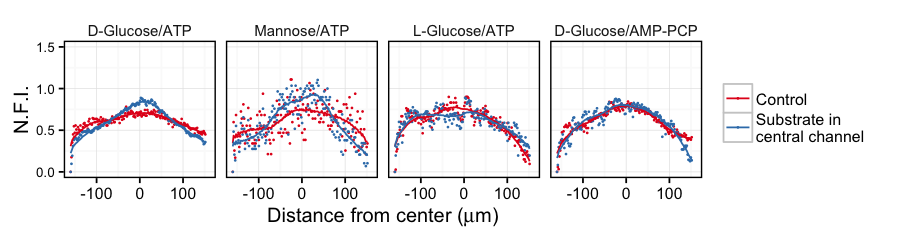

In [21]:
# PLOTTING THE CURVES

options(repr.plot.width = 7.5, repr.plot.height = 2)

raw <- ggplot(data = filter(fig3_recap),aes(x = distance-160,color = Experiment)) + 
    geom_point(aes(y = orig), size = 0.1) +
    geom_line(aes(y = smooth)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(dg = 'D-Glucose/ATP',lg = 'L-Glucose/ATP', mannose = 'Mannose/ATP',
                                       amppcp = "D-Glucose/AMP-PCP"))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=8),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
    annotate("rect", xmin = -160, xmax = -60, ymin = 0.00002, ymax = +.000092, alpha = .2) +
    annotate("rect", xmin = 60, xmax = 160, ymin = 0.00002, ymax = +.000092, alpha = .2) +
scale_color_brewer(palette = 'Set1',labels = c("Control","Substrate in\ncentral channel")) +
coord_cartesian(ylim=c(0,1.5))

    
print(raw)

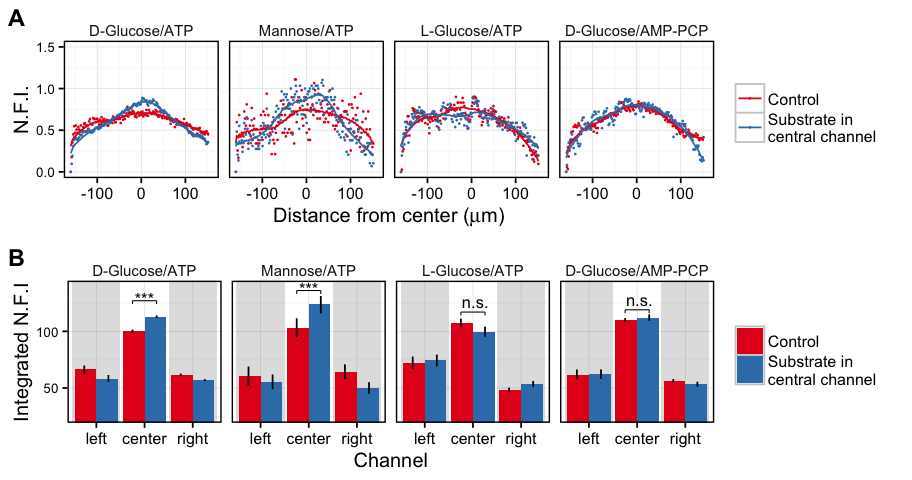

In [22]:
# PLOTTING THE FINAL FIGURE

options(repr.plot.width = 7.6, repr.plot.height = 4)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 1)

In [23]:
# saving the final figure

ggsave("../img/FocusingExperimentPlot_v4.png",width = 7.6, height = 4)